# Missing values and resampling

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

## Missing value imputation

This notebook demonstrates a version of ["hot-deck" missing value imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)).

First I'll load a dataset from the General Social Survey (GSS).

In [42]:
# Load the data file

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.hdf5

In [3]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 165)

It includes 64814 respondents and 165 variables for each respondent.

Suppose we want to run a model that compares income for men and women, controlling for age and education level.

Here's what it looks like if we don't fill missing data.

In [43]:
gss['age2'] = gss['age']**2
gss['educ2'] = gss['educ']**2

model = smf.ols('realinc ~ educ + educ2 + age + age2 + C(sex)', data=gss)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realinc   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     2605.
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:12:35   Log-Likelihood:            -6.7458e+05
No. Observations:               58110   AIC:                         1.349e+06
Df Residuals:                   58104   BIC:                         1.349e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.452e+04   1384.380    -17.713      0.000   -2.72e+04   -2.18e+04
C(sex)[T.2] -4612.6446    222.704    -20.712      0.000   -5049.145   -4176.144
educ         -294.8175    168.502     -1.750      0.080    -625.082      35.447
educ2         143.3503      6.622     21.648      0.000     130.371     156.329
age          1698.3989     36.532     46.491      0.000    1626.797    1770.001
age2          -16.9586      0.365    -46.436      0.000     -17.674     -16.243
==============================================================================
Omnibus:                    20760.569   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74398.723
Skew:                           1.807   Prob(JB):                         0.00
Kurtosis:                       7.203   Cond. No.                     3.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Notice that the number of observations is 58110.  The model has quietly dropped respondents who are missing any of the independents variables or the dependent variable.

We can plot the results like this.

In [44]:
def plot_results(results):
    df = pd.DataFrame()
    df['age'] = np.linspace(18, 89)
    df['educ'] = 16

    df['age2'] = df['age']**2
    df['educ2'] = df['educ']**2

    df['sex'] = 1
    pred1 = results.predict(df)
    pred1.index = df['age']

    df['sex'] = 2
    pred2 = results.predict(df)
    pred2.index = df['age']
    
    pred1.plot(label='Male', alpha=0.6)
    pred2.plot(label='Female', alpha=0.6)

    plt.xlabel('Age')
    plt.ylabel('Real income (1986 $)')
    plt.title('Real income versus age, grouped by sex')
    plt.legend()

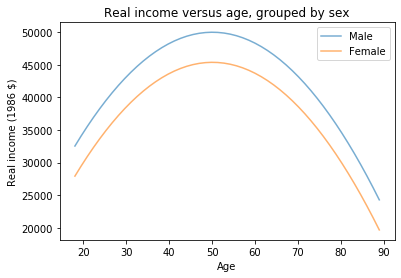

In [45]:
plot_results(results)

Let's see where those missing values are.

In [7]:
gss['age'].isna().sum()

228

There are 228 respondents with unknown age.

In [8]:
gss['educ'].isna().sum()

177

There are 177 respondents with unknown education level.

In [9]:
gss['sex'].isna().sum()

0

There are no respondents with unknown sex.

In [10]:
gss['realinc'].isna().sum()

6521

And there are 6521 respondents with unknown income.  So let's start filling things in.

The following function takes a Pandas Series and modifies it in place, replacing any NaN values with randomly-chosen valid values.

In [46]:
def fill_missing_values(series):
    """Fills missing values of the given Series.

    series: Pandas Series
    """
    # Boolean Series: true where values are missing
    null = series.isnull()

    # Series of valid values
    valid = series.dropna()
    
    # the fill values are a sample of the valid values 
    fill = valid.sample(null.sum(), replace=True)
    
    # we need the index of the fill values to line up
    # with the index of the DataFrame
    fill.index = series.index[null]

    # replace NaNs with the fill values
    series.fillna(fill, inplace=True)

Now, I will fill missing values for `age` and `educ`.

In [47]:
varnames = ['age', 'educ']
for varname in varnames:
    fill_missing_values(gss[varname])

And we can confirm that there are no NaNs left.

In [13]:
gss['age'].isna().sum()

0

In [14]:
gss['educ'].isna().sum()

0

I will not bother to fill `realinc` because it is the dependent variable.

Filling in the independent variables make it possible to include respondents with partial information, so it helps by adding information to the model.

Filling in the dependent variable would do nothing but add randomness to the results.  If the missing values introduce sampling bias (for example, if people with high income are less likely to respond), filling missing values would not help with that problem.

Now I'll run the model again with the filled data.

In [48]:
gss['age2'] = gss['age']**2
gss['educ2'] = gss['educ']**2

model2 = smf.ols('realinc ~ educ + educ2 + age + age2 + C(sex)', data=gss)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realinc   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     2605.
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:49:36   Log-Likelihood:            -6.7674e+05
No. Observations:               58293   AIC:                         1.353e+06
Df Residuals:                   58287   BIC:                         1.354e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.451e+04   1381.328    -17.743      0.000   -2.72e+04   -2.18e+04
C(sex)[T.2] -4636.0289    222.482    -20.838      0.000   -5072.095   -4199.962
educ         -280.3947    168.059     -1.668      0.095    -609.791      49.002
educ2         142.6127      6.605     21.590      0.000     129.666     155.559
age          1695.1496     36.486     46.461      0.000    1623.637    1766.662
age2          -16.9267      0.365    -46.415      0.000     -17.641     -16.212
==============================================================================
Omnibus:                    20842.655   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74760.189
Skew:                           1.808   Prob(JB):                         0.00
Kurtosis:                       7.207   Cond. No.                     3.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

And plot the results.

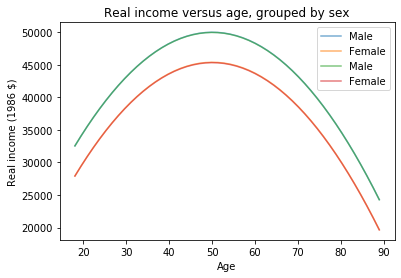

In [16]:
plot_results(results)
plot_results(results2)

There is no visible difference between the results with and without filling, which suggests that for this dataset missing data is not a substantial source of uncertainty.

If it were, I would consider other ways of imputing missing values, including [regression](https://en.wikipedia.org/wiki/Imputation_(statistics)#Regression).

## Resampling

Next we'll use resampling to quantify variability in the model due to random sampling.  The following function takes a DataFrame and resamples the rows.

In [17]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

The GSS uses stratified sampling, which means that some groups are deliberately oversampled.  The variable `wtssall` contains sampling weights, which we use during resampling to undersample the groups that were oversampled, and vice versa.

As a result, in the resampled dataset, every row has the same sampling weight; that is, the resampled dataset is representative of the population.

In the GSS dataset, the sampling weights are computed for each cycle of data collection, so I'll group the dataset by year, resample within each year, and then put the results back into one DataFrame.

In [49]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby('year')
    samples = [resample_rows_weighted(group, column)
               for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

Here's how we use these functions:

In [19]:
gss = pd.read_hdf(datafile, 'gss')
sample = resample_by_year(gss, 'wtssall')

The following function takes a resampled dataset, runs the model, and returns the results.

In [50]:
def run_model(df):
    varnames = ['age', 'educ']
    for varname in varnames:
        fill_missing_values(df[varname])
    
    df['age2'] = df['age']**2
    df['educ2'] = df['educ']**2

    model = smf.ols('realinc ~ educ + educ2 + age + age2 + C(sex)', data=df)
    results = model.fit()
    return results

Here's how we can use it with one resampled dataset.

In [51]:
results3 = run_model(sample)
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realinc   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     2396.
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:55:14   Log-Likelihood:            -6.7331e+05
No. Observations:               57712   AIC:                         1.347e+06
Df Residuals:                   57706   BIC:                         1.347e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.335e+04   1453.046    -16.070      0.000   -2.62e+04   -2.05e+04
C(sex)[T.2] -4010.7110    235.822    -17.007      0.000   -4472.924   -3548.498
educ          -72.5272    178.890     -0.405      0.685    -423.152     278.097
educ2         143.2837      7.059     20.299      0.000     129.448     157.119
age          1652.1489     38.586     42.817      0.000    1576.520    1727.778
age2          -16.5914      0.396    -41.845      0.000     -17.369     -15.814
==============================================================================
Omnibus:                    17926.666   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52014.279
Skew:                           1.645   Prob(JB):                         0.00
Kurtosis:                       6.286   Cond. No.                     3.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now we can compare the results with the original and resampled datasets.

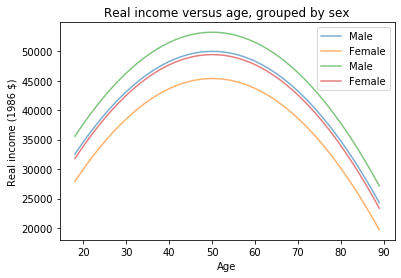

In [22]:
plot_results(results)
plot_results(results3)

In this example, there is a substantial difference, which suggests that the groups that were oversampled tended to have lower incomes.  When we use resampling to correct for stratified sampling, predicted incomes increase.

## Confidence intervals

We can use repeated resampling to generate confidence intervals.  The following look resamples the dataset 11 times, runs the model, and collects the results.

In [53]:
result_seq = []
gss = pd.read_hdf(datafile, 'gss')

for i in range(11):
    sample = resample_by_year(gss, 'wtssall')
    results = run_model(sample)
    result_seq.append(results)

I'll use the following function to generate predictions for each resampled dataset.

In [54]:
def make_predict(results, sex):
    df = pd.DataFrame()
    df['age'] = np.linspace(18, 89)
    df['educ'] = 16

    df['age2'] = df['age']**2
    df['educ2'] = df['educ']**2

    df['sex'] = sex
    pred = results.predict(df)
    pred.index = df['age']
    return pred

A quick way to visualize variability due to sampling is to plot predictions for each of the resampled dataset using a low value of `alpha`.

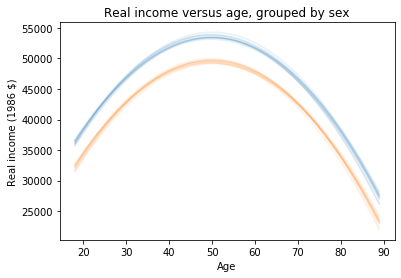

In [55]:
for results in result_seq:
    pred = make_predict(results, 1)
    pred.plot(color='C0', alpha=0.1)

for results in result_seq:
    pred = make_predict(results, 2)
    pred.plot(color='C1', alpha=0.1)
    
plt.xlabel('Age')
plt.ylabel('Real income (1986 $)')
plt.title('Real income versus age, grouped by sex');

And alternative is to collect the predictions in a list:

In [41]:
result_seq = []
gss = pd.read_hdf(datafile, 'gss')

for i in range(51):
    sample = resample_by_year(gss, 'wtssall')
    results = run_model(sample)
    result_seq.append(results)

The result is a list of Series, but we can treat it as an array with one row for each resampled dataset and one column for each of the ages in the range.

Then we can use `np.percentiles` to compute the 5th, 50th, and 95th percentile in each columns (`axis=0` means we perform the computation along the first axis, which is down the columns).

The result is an array with 3 rows, which we can assign to variables.  Then we use `fill_between` to plot the area between the 5th and 95th percentiles, and `plot` to draw a line through the median values.

In [56]:
def plot_percentiles(result_seq, sex, **options):
    pred_list = []

    for results in result_seq:
        pred = make_predict(results, sex)
        pred_list.append(pred)

    low, med, high = np.percentile(pred_list, [5, 50, 95], axis=0)
    plt.fill_between(pred.index, low, high, alpha=0.3)
    plt.plot(pred.index, med, **options)

Here's what it looks like.

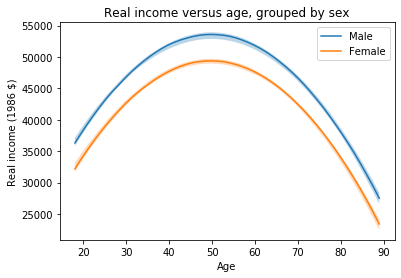

In [40]:
plot_percentiles(result_seq, 1, label='Male')
plot_percentiles(result_seq, 2, label='Female')

plt.xlabel('Age')
plt.ylabel('Real income (1986 $)')
plt.title('Real income versus age, grouped by sex')
plt.legend();

The 90% confidence intervals are barely wider than the plotted lines, which suggests that random sampling is not a big source of uncertainty.

In summary, for this example:

1. Missing values are not a substantial source of uncertainty, so we could use a simple form of imputation, or (even simpler) drop rows with missing values.

2. Stratified sampling has a big effect on the results, so it is important to correct for it.

3. The confidence intervals show that random sampling contributes only small variations in the model's predictions.